# Energy eigenstates of the finite 1D square well potential
#### Russell Anderson, August 2019

### Preliminaries

In [444]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar

np.seterr(invalid="ignore")

### Solving the Schrödinger equation

The external potential $V(x)$ is a piecewise defined function for the square well, with depth $V_0$ and width $a$:
$$V(x) = \begin{cases} 0 & |x| \leq a/2 \\ V_0 & |x| > a/2 \end{cases} \, .$$

As we wish to pass array values to the position argument, we need to use a recursive definition if `x` is iterable (`abs(x)` returns an array of booleans when `x` is an array, which cannot be used in the `< a/2` inequality).

In [217]:
def V(x, V0=50, a=1):
    if np.iterable(x):
        return np.array([V(xi, V0, a) for xi in x])
    elif np.abs(x) < a/2:
        return 0
    else:
        return V0

The Schrödinger equation is:
$$\frac{d^2 \psi}{d x^2} = -\frac{2 m}{\hbar} \left( E - V(x) \right) \psi(x) \, .$$

This is an ordinary second-order differential equation, with an unknown parameter $E$. We need to convert into a first-order differential equation to use the numerical methods offered by [`scipy.integrate`](https://docs.scipy.org/doc/scipy/reference/integrate.html), which we achieve by defining a vector $\mathbf{y}(x) = (y_1(x), y_2(x))$ with $y_1(x) = \psi(x)$ and $y_2(x) = \psi'(x)$. Then the above equation can be written:

$$\begin{align} y_1'(x) &= y_2(x) \\ y_2'(x) &= -\frac{2 m}{\hbar} \left( E - V(x) \right) y_1(x) \, .\end{align}$$

In the below, we set $\hbar = m = 1$ and define functions `fun(x, y, p)` and `bc(ya, yb, p)` which can be used in the boundary-value solver [`scipy.integrate.solve_bvp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html).

___
From the docs, the function `fun` represents the:

> Right-hand side of the system. The calling signature is `fun(x, y)`, or `fun(x, y, p)` if parameters are present. All arguments are ndarray: `x` with shape `(m,)`, `y` with shape `(n, m)`, meaning that `y[:, i]` corresponds to `x[i]`, and `p` with shape `(k,)`. The return value must be an array with shape (n, m) and with the same layout as y.

Here, `x` is the array of positions with first and last elements the boundary of the system, the vector `y` is as defined above, and we'll use the unknown parameter vector `p` to contain the energy eigenvalue (not known a priori). Thus, our dimensions will be $n=2$, $k=1$.

In [70]:
def fun(x, y, p):
    E = p[0]
    return np.vstack((y[1], -2*(E - V(x))*y[0]))

___
The function `bc` is a:
> Function evaluating residuals of the boundary conditions. The calling signature is `bc(ya, yb)`, or `bc(ya, yb, p)` if parameters are present. All arguments are ndarray: `ya` and `yb` with shape `(n,)`, and `p` with shape `(k,)`. The return value must be an array with shape `(n + k,)`.

We have to return $n+k=3$ residuals, corresponding to the boundary conditions $\psi(x_a) = 0$, $\psi(x_b) = 0$, and $\psi'(x_a) = \kappa$ where $\kappa$ is some small number quantifying the derivative of the solution at the boundary. Since the boudary is finite, this must be a small numeric quantity so that the solution can change from 0. The function takes as input the current value of $\mathbf{y}$ at the boundary, i.e. $$\mathbf{y}(x_a)=(y_1(x_a), y_2(x_a))$$ and $$\mathbf{y}(x_b) = (y_1(x_b), y_2(x_b)) \, ,$$and the parameter vector $\mathbf{p} = (E,)$.

The function then returns the residuals $(y_1(x_a) - 0, y_2(x_b) - 0, y_1'(x_a) - \kappa)$. This choice of boundary conditions is not unique. For alternatives, see [Schroeder's notes](https://physics.weber.edu/schroeder/quantum/Numerical.pdf) on this problem.

In [77]:
def bc(ya, yb, p):
    return np.array([ya[0], yb[0], ya[1] - 0.001])

___
We now initialise the 'mesh' upon which `solve_bvp` will use for the numerical integration. Here we choose $x \in [-1.5a, 1.5a]$, i.e. $x_a = -1.5 a$ and $x_b = 1.5 a$ for a potential width of $a=1$. This is sufficient room for the bound state solutions to decay to zero.

In [386]:
x = np.linspace(-1.5, 1.5, 11)

We also define the initial guess for $\mathbf{y}(x)$, sampled on the above mesh. This can be done very crudely, by setting the value of $y_1(x) = \psi(x)$ and $y_2(x) = \psi'(x)$ to be zero everywhere, except for a non-zero value of the wavefunction at a single point (offset from the origin, to permit even functions of $x$ to be found).

In [387]:
y_i = np.zeros((2, x.size))
y_i[0,4] = 0.1

___
Finally, we need to specify the initial guess for the energy. This choice will dictate _which_ energy eigenstate the algorithm converges upon.

So that we find a unique solution each time, we should make our best estimate of the energy eigenvalue. We can do this by using the relationship between $k_1 = \sqrt{2 m E}/\hbar$ and $k_2 = \sqrt{2 m (V_0 - E)}/\hbar$:

$$\begin{align} k_2 &= k_1 \tan\left( \frac{k_1 a}{2} \right) \quad (n\;\text{odd}) \\ -k_2 &= k_1 \cot\left( \frac{k_1 a}{2} \right) \quad (n\;\text{even}) \, .\end{align} $$

In [514]:
def fk(E, V0=50, a=1, n=1):
    """Returns the error in the equality:
        k2 = k1 * tan(k1 * a / 2) for odd n (even parity solutions); or
       -k2 = k1 * cot(k1 * a / 2) for even n (odd parity solutions),
        where k1 = sqrt(2 * E) and k2 = sqrt(2 * (V0 - E)) for E < V0.
    """
    k1 = np.sqrt(2 * E)
    k2 = np.sqrt(2 * (V0 - E))
    if n % 2:
        return k2 - k1 * np.tan(k1 * a / 2)
    else:
        return k2 + k1 / np.tan(k1 * a / 2)


def Eanalytic(V0=50, a=1, pts=100):
    """Finds the roots of the fk between 0 and V0 for odd and even n."""
    Ei = np.linspace(0.0, V0, pts)
    roots = []
    for n in [1, 2]:
        for i in range(pts - 1):
            soln = root_scalar(fk, args=(V0, a, n), x0=Ei[i], x1=Ei[i + 1])
            if soln.converged and np.around(soln.root, 9) not in roots:
                roots.append(np.around(soln.root, 9))
    return np.sort(roots)


Elist = Eanalytic()
print(Elist)

[ 3.41357099 13.47572274 29.45230759 48.14346422]


___
Equipped with (very good) estimates of the energy eigenvalues, we proceed to solve the differential equation using `solve_bvp` for each energy eigenstate. The estimates are  

In [394]:
solns = [solve_bvp(fun, bc, x, y_i, p=[Ei]) for Ei in Elist]

In [395]:
for i, soln in enumerate(solns):
    print(f"n = {i+1}:", "success = {success}; niter = {niter}".format(**soln))

n = 1: success = False; niter = 34
n = 2: success = False; niter = 35
n = 3: success = False; niter = 36
n = 4: success = False; niter = 198


How do the eigenvalues found using `solve_bvp` compare to the analytic estimates?

In [397]:
np.array([soln.p[0] - Ei for soln, Ei in zip(solns, Elist)])

array([6.59267306e-05, 3.48799999e-04, 2.47946173e-03, 1.17498946e-01])

### Visualising the eigenstates

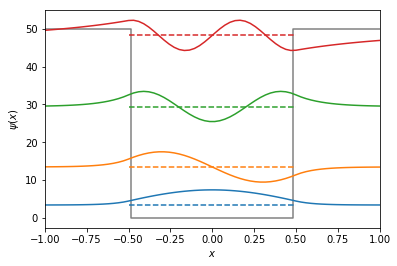

In [399]:
x_plot = np.linspace(x.min(), x.max(), 100)
plt.plot(x_plot, V(x_plot), drawstyle='steps-mid', c='k', alpha=0.5)
for soln in solns:
    y_plot = soln.sol(x_plot)[0]
    l = plt.plot(x_plot, 4 * y_plot / y_plot.max() + soln.p[0])
    plt.axhline(soln.p[0], xmin=0.25, xmax=0.75, ls='--', c=l[0].get_color())
plt.axis(xmin=-1, xmax=1)
plt.xlabel(r'$x$')
plt.ylabel(r'$\psi(x)$')
plt.show()

### Probability density

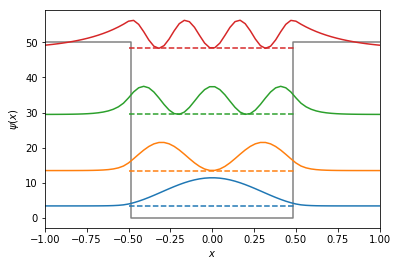

In [400]:
x_plot = np.linspace(x.min(), x.max(), 100)
plt.plot(x_plot, V(x_plot), drawstyle='steps-mid', c='k', alpha=0.5)
for soln in solns:
    y_plot = soln.sol(x_plot)[0]
    l = plt.plot(x_plot, 8 * y_plot**2 / y_plot.max()**2 + soln.p[0])
    plt.axhline(soln.p[0], xmin=0.25, xmax=0.75, ls='--', c=l[0].get_color())
plt.axis(xmin=-1, xmax=1)
plt.xlabel(r'$x$')
plt.ylabel(r'$\psi(x)$')
plt.show()

### Comparison between infinite and finite square wells

In [439]:
def E_inf(n, a=1):
    """n-th energy eigenvalue of the 1D infinite square well potential"""
    return n**2 * np.pi**2 / (2 * a**2)

def psi_inf(x, n, a=1):
    """n-th energy eigenstate of the 1D infinite square well potential"""
    if np.iterable(x):
        return np.array([psi_inf(xi, n, a) for xi in x])
    elif np.abs(x) < a/2:
        phase = n * np.pi * x / a
        return np.cos(phase) if n % 2 else np.sin(phase)
    else:
        return 0

#### Annotated wavefunction comparison

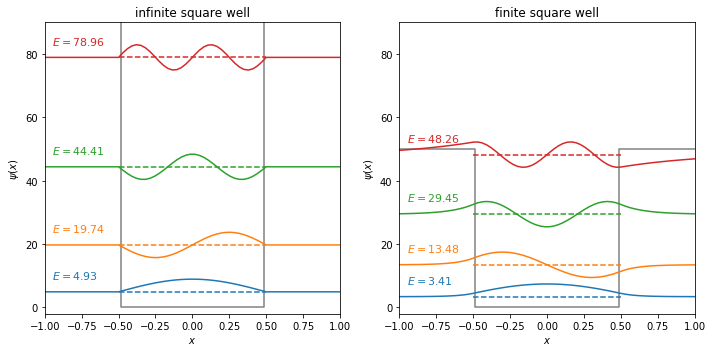

In [515]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(x_plot, V(x_plot, V0=100), drawstyle="steps-mid", c="gray")
for n in np.arange(len(solns)) + 1:
    y_plot = psi_inf(x_plot, n)
    l = plt.plot(x_plot, 4 * y_plot + E_inf(n))
    col = l[0].get_color()
    plt.axhline(E_inf(n), xmin=0.25, xmax=0.75, ls="--", c=col)
    plt.text(-0.95, E_inf(n) + 4, f"$E = {E_inf(n):.2f}$", color=col, fontsize=11)
plt.axis(xmin=-1, xmax=1, ymin=-2, ymax=90)
plt.xlabel(r"$x$")
plt.ylabel(r"$\psi(x)$")
plt.title("infinite square well")

plt.subplot(122)
plt.plot(x_plot, V(x_plot), drawstyle="steps-mid", c="gray")
for soln in solns:
    y_plot = soln.sol(x_plot)[0]
    En = soln.p[0]
    l = plt.plot(x_plot, 4 * y_plot / y_plot.max() + En)
    col = l[0].get_color()
    plt.axhline(En, xmin=0.25, xmax=0.75, ls="--", c=col)
    plt.text(-0.95, En + 4, f"$E = {En:.2f}$", color=col, fontsize=11)
plt.axis(xmin=-1, xmax=1, ymin=-2, ymax=90)
plt.xlabel(r"$x$")
plt.ylabel(r"$\psi(x)$")
plt.title("finite square well")
plt.savefig("square_well_comparison.png")
plt.tight_layout()
plt.show()

#### Annotated probability density comparison

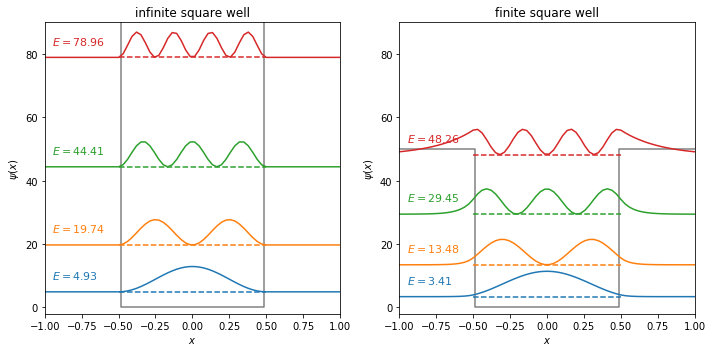

In [432]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(x_plot, V(x_plot, V0=100), drawstyle="steps-mid", c="gray")
for n in np.arange(len(solns)) + 1:
    y_plot = psi_inf(x_plot, n)
    l = plt.plot(x_plot, 8 * y_plot ** 2 + E_inf(n))
    col = l[0].get_color()
    plt.axhline(E_inf(n), xmin=0.25, xmax=0.75, ls="--", c=col)
    plt.text(-0.95, E_inf(n) + 4, f"$E = {E_inf(n):.2f}$", color=col, fontsize=11)
plt.axis(xmin=-1, xmax=1, ymin=-2, ymax=90)
plt.xlabel(r"$x$")
plt.ylabel(r"$\psi(x)$")
plt.title("infinite square well")

plt.subplot(122)
plt.plot(x_plot, V(x_plot), drawstyle="steps-mid", c="gray")
for soln in solns:
    y_plot = soln.sol(x_plot)[0]
    En = soln.p[0]
    l = plt.plot(x_plot, 8 * (y_plot / y_plot.max()) ** 2 + En)
    col = l[0].get_color()
    plt.axhline(En, xmin=0.25, xmax=0.75, ls="--", c=col)
    plt.text(-0.95, En + 4, f"$E = {En:.2f}$", color=col, fontsize=11)
plt.axis(xmin=-1, xmax=1, ymin=-2, ymax=90)
plt.xlabel(r"$x$")
plt.ylabel(r"$\psi(x)$")
plt.title("finite square well")

plt.tight_layout()
plt.show()

### Fraction of wavefunction in nonclassical region

We evaluate the fraction of the wavefunction in the non-classical region ($|x| > a/2$) by integrating the probability distribution $|\psi(x)|^2$ in this region.

The numerical wavefunctions are not normalised, so we first find the integral $\int_{x_a}^{x_b} |\psi(x)|^2 dx$ and create a probability distribution from this.

While we're at it, we also find the first and second moments of the probability distribution, $\langle x \rangle$ and $\langle x^2 \rangle$ for the bound states. The root-mean-square (rms) width of the distribution is given by $\sqrt{\langle x^2 \rangle}$.

In [426]:
dx = np.diff(x_plot)[0]
x_rms_list = []
for i, soln in enumerate(solns):
    psi_squared = soln.sol(x_plot)[0] ** 2
    Ptot = psi_squared.sum() * dx
    Prob = psi_squared / Ptot
    tunnel_fraction = Prob[np.abs(x_plot) > 0.5].sum() * dx
    x_expect = (Prob * x_plot).sum()
    x2_expect = (Prob * x_plot ** 2).sum()
    x_rms_list.append(np.sqrt(x2_expect))
    print(
        f"n = {i+1}: {100*tunnel_fraction:05.2f}%; <x> = {abs(x_expect):.2f}; x_rms = {np.sqrt(x2_expect):.2f}"
    )

The expectation value $\langle x^2 \rangle$ has an analytic form for the infinite square well. Let's compare it to the finite well for the bound states.

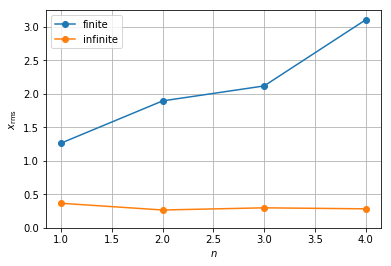

In [454]:
n_list = np.arange(len(solns)) + 1


def x2_inf(n, a=1):
    """expectation value of x^2 for the n-th energy eigenstate of the 1D infinite square well"""
    s = 2 * (n % 2) - 1
    return a ** 2 * (1.0 / 12 + s / (2 * np.pi ** 2 * n ** 2))


x_rms_inf = np.sqrt(x2_inf(n_list))

plt.plot(n_list, x_rms_list, label="finite", marker="o")
plt.plot(n_list, x_rms_inf, label="infinite", marker="o")
plt.xlabel(r"$n$")
plt.ylabel(r"$x_{\rm rms}$")
plt.legend()
plt.grid()
plt.axis(ymin=0)
plt.show()

### Orthogonality of different eigenstates

Finally, we compute the overlap integral $\int_{-\infty}^{\infty} \psi_i^*(x) \psi_j(x) dx$ for all combinations of $i$ and $j$, to show that these wavefunctions are orthogonal.

Doing so requires we normalise the wavefunctions so that the absolute value of the integral is meaningful. In principle, it should be equal to $\delta_{ij}$.

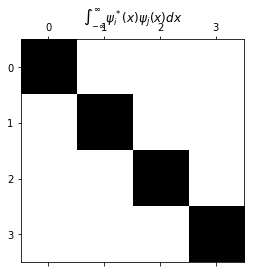

In [513]:
M = []
for i in range(4):
    psi_i = solns[i].sol(x_plot)[0]
    psi_i /= np.sqrt((psi_i**2).sum() * dx)
    for j in range(4):
        psi_j = solns[j].sol(x_plot)[0]
        psi_j /= np.sqrt((psi_j**2).sum() * dx)
        M.append(np.dot(psi_i, psi_j) * dx)

M = np.reshape(M, (4,4))

plt.matshow(np.reshape(M, (4,4)), cmap='bone_r')
plt.title(r"$\int_{-\infty}^{\infty} \psi_i^*(x) \psi_j(x) dx$")
plt.tight_layout()
plt.show()